In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import linregress

# Define a function to randomly add a grain to the edge of the system
@jit(nopython=True)
def add_grain_on_edge(grid, L):
    edge_choice = np.random.randint(4)  # Randomly choose an edge, 0: top, 1: bottom, 2: left, 3: right
    
    if edge_choice == 0:  # Top edge y = 0
        x = np.random.randint(0, L)
        y = 0
    elif edge_choice == 1:  # Bottom edge y = L-1
        x = np.random.randint(0, L)
        y = L - 1
    elif edge_choice == 2:  # Left edge x = 0
        x = 0
        y = np.random.randint(0, L)
    else:  # Right edge x = L-1
        x = L - 1
        y = np.random.randint(0, L)
    
    grid[x, y] += 1
    return x, y

# Handle collapse, moving grains to the four surrounding lattice points
@jit(nopython=True)
def collapse(grid, L):
    total_avalanche_size = 0
    directions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])  # up, down, left, right
    max_x_extent = 0
    max_y_extent = 0
    
    # Continue collapsing until all unstable sites are stabilized
    while np.max(grid > 1):
        topple_sites = np.argwhere(grid > 1)  # Find all sites that need to collapse
        total_avalanche_size += len(topple_sites)  # Add the number of unstable sites to the avalanche size
        x_min, x_max = topple_sites[:, 0].min(), topple_sites[:, 0].max()
        y_min, y_max = topple_sites[:, 1].min(), topple_sites[:, 1].max()
        
        max_x_extent = max(max_x_extent, 1 + x_max - x_min)  # Update max extent in the x-direction
        max_y_extent = max(max_y_extent, 1 + y_max - y_min)  # Update max extent in the y-direction

        for site in topple_sites:
            x, y = site
            grid[x, y] -= 2  # Remove two grains from the current site
            
            # Randomly move two grains to neighboring sites
            for _ in range(2):
                direction = np.random.randint(4)
                dx, dy = directions[direction]
                new_x, new_y = x + dx, y + dy
                
                # Check if the new position is within bounds
                if 0 <= new_x < L and 0 <= new_y < L:
                    grid[new_x, new_y] += 1  # Add one grain to the neighboring site
                else:
                    # Grains move out of the system if they reach the boundary
                    pass
    
    return total_avalanche_size, max(max_x_extent, max_y_extent)

# Simulate the evolution of the system
@jit(nopython=True)
def simulate(grid, max_steps, L, n_0):
    avalanche_sizes = []
    max_extents = []
    
    for step in range(max_steps):
        # Randomly add a grain to the edge
        add_grain_on_edge(grid, L)
        
        # Handle collapse until the system stabilizes
        total_avalanche_size, max_extent = collapse(grid, L)
        
        # Record avalanche events after step n_0
        if step >= n_0:
            avalanche_sizes.append(total_avalanche_size)
            max_extents.append(max_extent)
    
    return np.array(avalanche_sizes), np.array(max_extents)

# Set values for L
L_values = [25, 50, 100, 200]  # Set different L values
max_steps = 3000000  # Maximum number of steps
n_0 = 2000000  # Start recording avalanche events after step n_0

# Store simulation results for all L values
all_avalanche_sizes = {}
all_max_extents = {}

# Run the simulation for each L value
for L in L_values:
    grid = np.zeros((L, L), dtype=int)
    avalanche_sizes, max_extents = simulate(grid, max_steps, L, n_0)
    all_avalanche_sizes[L] = avalanche_sizes
    all_max_extents[L] = max_extents


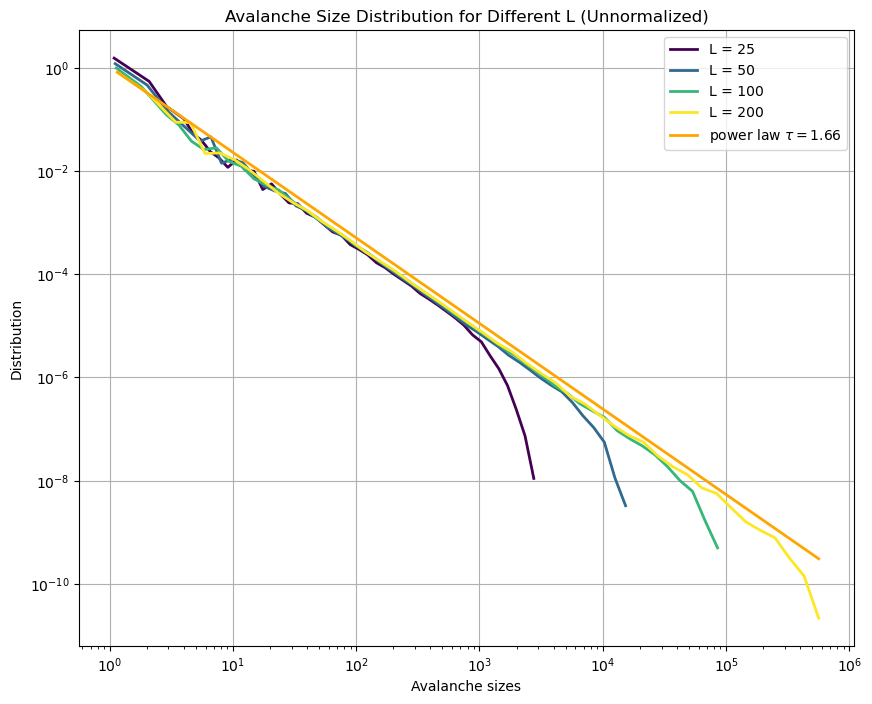

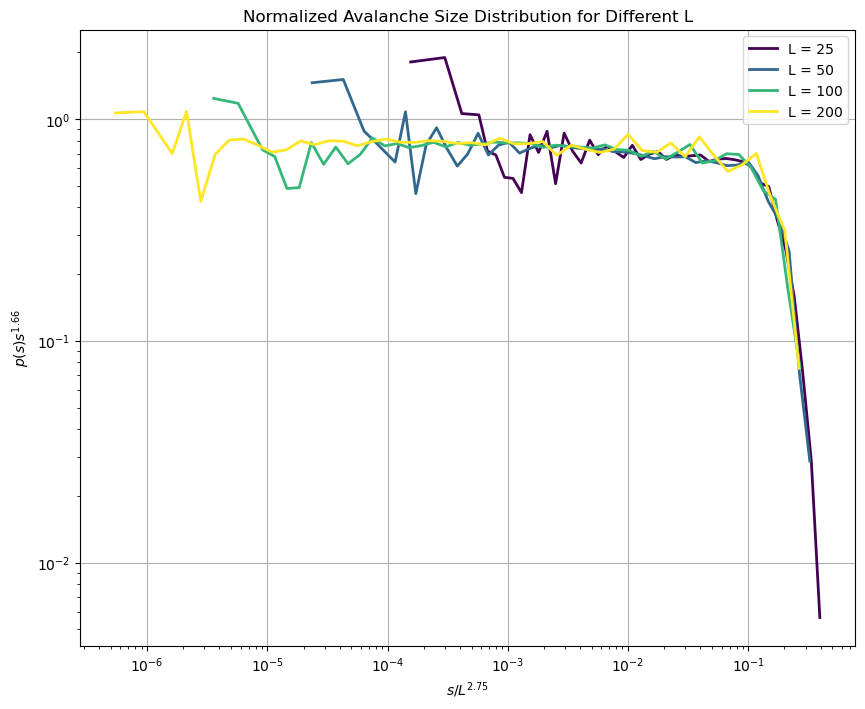

Steady state dynamics has been reached for L = 25.
Steady state dynamics has been reached for L = 50.
Steady state dynamics has not been reached yet for L = 100.
Steady state dynamics has not been reached yet for L = 200.


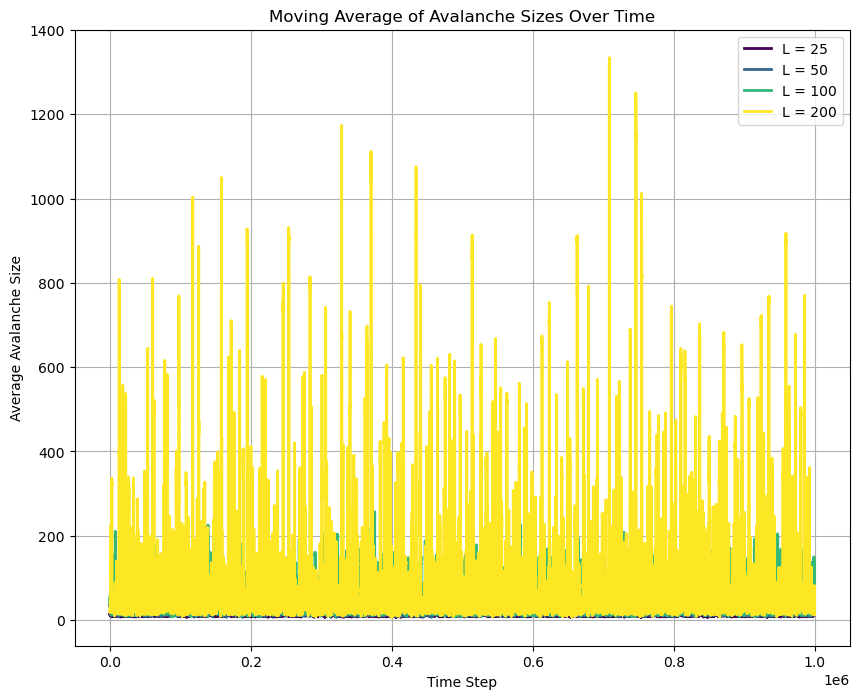

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Use matplotlib's colormap to generate a list of colors corresponding to the length of L_values
colors = cm.viridis(np.linspace(0, 1, len(L_values)))  # 'viridis' is a colormap, you can replace it with others

# -------------------------- Figure 1: Unnormalized Distribution -------------------------- #
plt.figure(figsize=(10, 8))

max_L = max(L_values)    # Maximum L value
power_law_plotted = False
max_L_hist = None
max_L_bin_centers = None

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Compute the histogram of avalanche sizes, removing zero values to avoid vertical lines
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero-value points
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    # Plot the unnormalized distribution curve
    plt.loglog(bin_centers, hist, label=f'L = {L}', lw=2, color=color)
    
    # Save the data for the largest L to align with the power law curve
    if L == max_L:
        max_L_hist = hist
        max_L_bin_centers = bin_centers
    
    # Plot the power-law curve τ=1.3, aligned with the largest L data
    if not power_law_plotted and max_L_hist is not None:
        tau = 1.66
        power_law = max_L_bin_centers ** (-tau)
        # Align the power-law curve with the first point of the largest L
        power_law *= max_L_hist[0] / power_law[0]  
        plt.loglog(max_L_bin_centers, power_law, label=fr'power law $\tau = {tau:.2f}$', lw=2, color='orange')
        power_law_plotted = True

# Plot formatting
plt.xlabel('Avalanche sizes')
plt.ylabel('Distribution')
plt.title('Avalanche Size Distribution for Different L (Unnormalized)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------- Figure 2: Normalized Distribution -------------------------- #
plt.figure(figsize=(10, 8))

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Compute the histogram of avalanche sizes
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero-value points
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    # Calculate the distribution p(s) * s^tau
    tau = 1.66
    adjusted_hist = hist * bin_centers ** tau
    
    # Normalize avalanche sizes s / L^2
    normalized_sizes = bin_centers / (L ** 2.75)
    
    # Plot the normalized distribution curve
    plt.loglog(normalized_sizes, adjusted_hist, label=f'L = {L}', lw=2, color=color)

# Plot formatting
plt.xlabel(r'$s/L^{2.75}$')
plt.ylabel(r'$p(s) s^{1.66}$')
plt.title('Normalized Avalanche Size Distribution for Different L')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------- Figure 3: System Stability Plot -------------------------- #

# Calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Check if the system has reached a steady state
def check_steady_state(avalanche_sizes, window_size=500, tolerance=28):
    moving_std = np.std(moving_average(avalanche_sizes, window_size))
    return moving_std < tolerance

window_size = 500

plt.figure(figsize=(10, 8))

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Calculate the moving average
    avg_avalanche_sizes = moving_average(avalanche_sizes, window_size)
    
    # Check if the system has reached a steady state
    steady_state_reached = check_steady_state(avalanche_sizes)
    if steady_state_reached:
        print(f"Steady state dynamics has been reached for L = {L}.")
    else:
        print(f"Steady state dynamics has not been reached yet for L = {L}.")
    
    # Plot the change in moving average over time
    plt.plot(avg_avalanche_sizes, label=f'L = {L}', lw=2, color=color)

# Plot formatting
plt.xlabel('Time Step')
plt.ylabel('Average Avalanche Size')
plt.title('Moving Average of Avalanche Sizes Over Time')
plt.grid(True)
plt.legend()
plt.show()


In [12]:
import numpy as np
from scipy import stats
from collections import Counter

# Function to fit log-log regression with log base 10, specific size range filtering for different L values, and aggregate all data for regression
def fit_log_log_regression_aggregate(avalanche_sizes_dict, L_values):
    all_filtered_sizes = []
    
    # Define the size ranges for different L values
    size_ranges = {25: (0, 700), 50: (0, 700), 100: (0, 700), 200: (0, 700)}
    
    # Filter and aggregate data from all system sizes
    for L in L_values:
        avalanche_sizes = avalanche_sizes_dict[L]
        min_size, max_size = size_ranges.get(L, (1, np.inf))  # Default range if L is not in size_ranges
        
        # Filter out avalanche sizes of 0 and outside the specified range
        filtered_sizes = avalanche_sizes[(avalanche_sizes > 0) & (avalanche_sizes >= min_size) & (avalanche_sizes <= max_size)]
        all_filtered_sizes.extend(filtered_sizes)
    
    # Count frequencies of all filtered sizes
    size_counts = Counter(all_filtered_sizes)
    total_avalanches = sum(size_counts.values())
    
    if total_avalanches == 0:
        return np.nan, np.nan  # If no avalanches in the range, return NaN
    
    # Create list of [size, frequency]
    size_freq_list = np.array([[size, count / total_avalanches] for size, count in size_counts.items()])
    
    # Take log10 of both size and frequency
    log_sizes = np.log10(size_freq_list[:, 0])
    log_freqs = np.log10(size_freq_list[:, 1])
    
    # Perform linear regression on log-log data
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_sizes, log_freqs)
    
    # Return slope and R^2 value (r_value**2 gives R²)
    return slope, r_value**2

# Example usage:
L_values = [25, 50, 100, 200]
slope, r_squared = fit_log_log_regression_aggregate(all_avalanche_sizes, L_values)
print("Slope:", slope)
print("R^2:", r_squared)


Slope: -1.6609534987838486
R^2: 0.9949675648685997


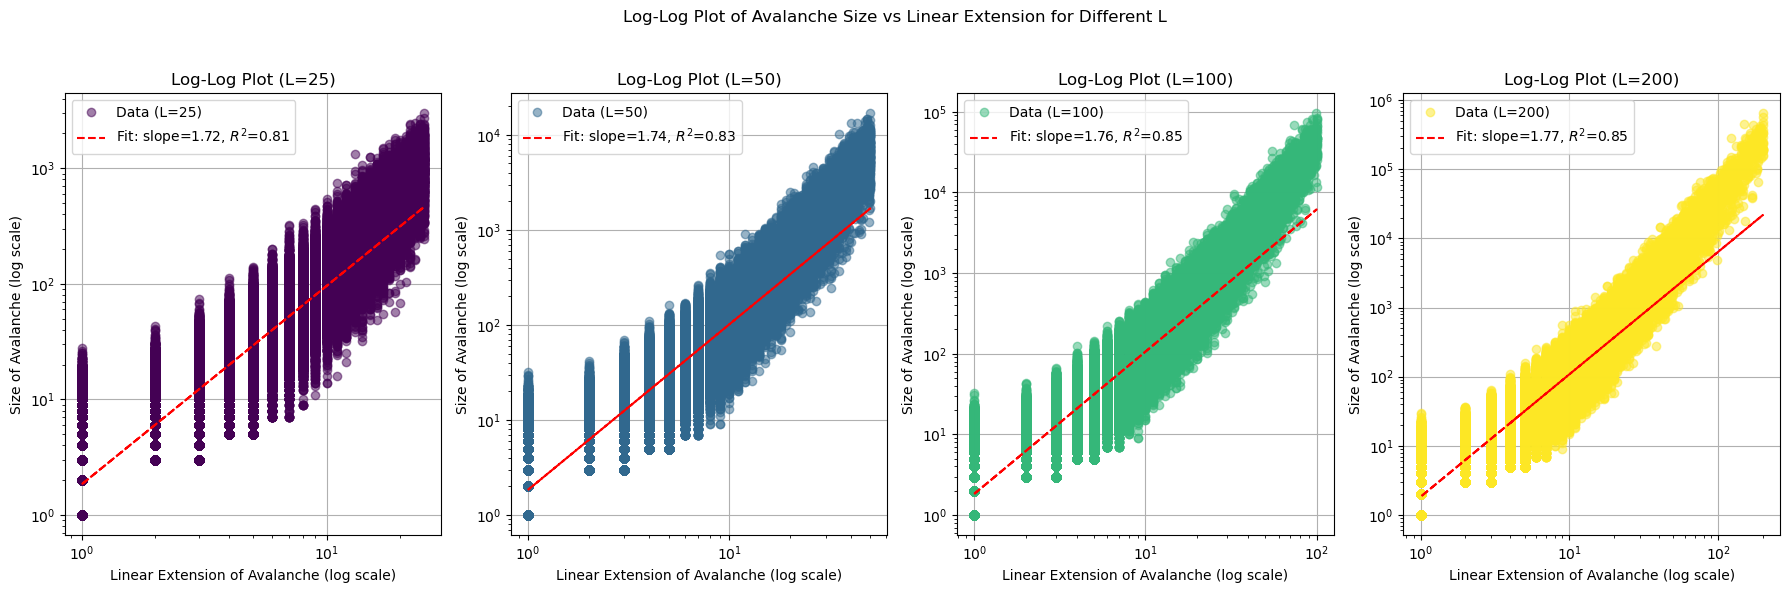

L=25: slope=1.72, R^2=0.81
L=50: slope=1.74, R^2=0.83
L=100: slope=1.76, R^2=0.85
L=200: slope=1.77, R^2=0.85


In [11]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Assume all_avalanche_sizes and all_max_extents contain recorded data for different L values
# L_values can be adjusted as needed
L_values = list(all_avalanche_sizes.keys())  # Automatically generate a list of L values from the dictionary
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))  # Dynamically generate a list of colors

# Create subplots, dynamically generating based on the number of L values
fig, axs = plt.subplots(1, len(L_values), figsize=(18, 6))

# Store the fit results (slope and R^2) for each L value
fit_results = {}

# Loop through the different L values and plot the log-log fit curve for each
for i, (L, color) in enumerate(zip(L_values, colors)):
    avalanche_sizes = all_avalanche_sizes[L]
    max_extents = all_max_extents[L]

    # Remove zero values to avoid log(0) calculation issues
    non_zero_indices = (avalanche_sizes > 0) & (max_extents > 0)
    avalanche_sizes = avalanche_sizes[non_zero_indices]
    max_extents = max_extents[non_zero_indices]

    # Plot log-log data
    axs[i].loglog(max_extents, avalanche_sizes, 'o', alpha=0.5, label=f'Data (L={L})', color=color)

    # Perform linear regression on the log-log data and calculate slope and R^2
    log_lin_arr = np.log10(max_extents)
    log_ava_arr = np.log10(avalanche_sizes)
    slope, intercept, r_value, p_value, std_err = linregress(log_lin_arr, log_ava_arr)
    
    # Store slope and R^2
    fit_results[L] = {'slope': slope, 'R^2': r_value**2}

    # Plot the fitted line
    fit_line = 10**(intercept) * max_extents**slope
    axs[i].loglog(max_extents, fit_line, 'r--', label=f'Fit: slope={slope:.2f}, $R^2$={r_value**2:.2f}')

    # Plot formatting
    axs[i].set_xlabel('Linear Extension of Avalanche (log scale)')
    axs[i].set_ylabel('Size of Avalanche (log scale)')
    axs[i].set_title(f'Log-Log Plot (L={L})')
    axs[i].grid(True)
    axs[i].legend()

# Set main title
fig.suptitle('Log-Log Plot of Avalanche Size vs Linear Extension for Different L')

# Adjust subplot layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

# Output the slope and R^2 for different L values
for L, result in fit_results.items():
    print(f"L={L}: slope={result['slope']:.2f}, R^2={result['R^2']:.2f}")
